In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-15 18:55:39--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M   175MB/s    in 1.6s    

2023-02-15 18:55:40 (175 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [2]:
import numpy as np
import json
import glob
import os
from pyspark.ml.feature import StringIndexer
import time
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import pandas as pd

In [3]:
import os
import sys

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [4]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
findspark.init()

In [5]:
# initiaiting spark context
sc = pyspark.SparkContext("local", appName="MillionSongs")

In [6]:
# open data directly from file
spark = SparkSession(sc)
df = spark.read.option("escape","\"").csv("/content/drive/MyDrive/bdp/final project/MILLION_SONGS.csv", header=True, sep=',', multiLine=True)

In [7]:
df.show(20)

+---+--------------------+-------------------+-------------------+--------------------+--------------------+---------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+---------+--------------+------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------

In [8]:
df = df.drop('transfer_note', 'Unnamed: 0', 'artist_7digitalid', 'artist_mbid', 'artist_mbtags', 'artist_mbtags_count', 'artist_playmeid', 'audio_md5', 'danceability', 'energy', 'release_7digitalid', 'similar_artists', 'song_id', 'track_7digitalid', 'analysis_sample_rate')

In [9]:
df = df.withColumn("artist_familiarity",f.col("artist_familiarity").cast("float"))
df = df.withColumn("duration",f.col("duration").cast("float"))
df = df.withColumn("end_of_fade_in",f.col("end_of_fade_in").cast("float"))
df = df.withColumn("key",f.col("key").cast("float"))
df = df.withColumn("key_confidence",f.col("key_confidence").cast("float"))
df = df.withColumn("loudness",f.col("loudness").cast("float"))
df = df.withColumn("mode",f.col("mode").cast("float"))
df = df.withColumn("start_of_fade_out",f.col("start_of_fade_out").cast("float"))
df = df.withColumn("tempo",f.col("tempo").cast("float"))
df = df.withColumn("time_signature",f.col("time_signature").cast("float"))
df = df.withColumn("time_signature_confidence",f.col("time_signature_confidence").cast("float"))
df = df.withColumn("year",f.col("year").cast("float"))

In [10]:
artist_fam_med = df.approxQuantile("artist_familiarity",[0.5],0)

In [11]:
df = df.fillna({'artist_familiarity':artist_fam_med[0]})
df = df.na.fill({'artist_location':''})
df = df.na.fill({'artist_name':''})
df = df.na.fill({'release':''})
df = df.na.fill({'title':''})

In [12]:
## Droping NaN for song_hotness
df = df.dropna(how='any',subset='song_hotttnesss')

In [13]:
df.show()

+---+------------------+-------------------+--------------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------+----+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|_c0|artist_familiarity|  artist_hotttnesss|           artist_id|artist_latitude|artist_longitude|     artist_location|         artist_name|             release|    song_hotttnesss|               title|        artist_terms|   artist_terms_

In [14]:
# Encode artist id and release
art_indexer = StringIndexer(inputCol='artist_id', outputCol='artist_idIndex')
rel_indexer = StringIndexer(inputCol='release', outputCol='releaseIndex')

In [15]:
df = art_indexer.fit(df).transform(df) 
df = rel_indexer.fit(df).transform(df)

In [16]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- artist_familiarity: float (nullable = false)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_location: string (nullable = false)
 |-- artist_name: string (nullable = false)
 |-- release: string (nullable = false)
 |-- song_hotttnesss: string (nullable = true)
 |-- title: string (nullable = false)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- artist_terms_weight: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- end_of_fade_in: float (nullable = true)
 |-- key: float (nullable = true)
 |-- key_confidence: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- mode_confidence: string (nullable = true)
 |-- start_of_fade_out: float (nullable = true)
 |-- tempo: float (nullable = tr

In [18]:
df.coalesce(1).write.mode('overwrite').csv('cleaned_data',header='true')

In [17]:
df = df.withColumn("song_hotttnesss",f.col("song_hotttnesss").cast("float"))
df = df.withColumn("song_hotttnesss", f.when(df['song_hotttnesss'] > 1,1).otherwise(df['song_hotttnesss'])).select("song_hotttnesss")

In [18]:
dfp = df.toPandas()

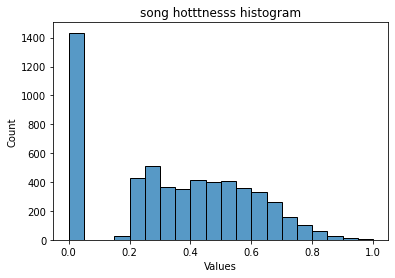

In [19]:
ax = sns.histplot(data=dfp['song_hotttnesss'],bins=20)
ax.set(title='song hotttnesss histogram', xlabel='Values');

In [ ]:
sc.stop()